In [1]:
import argparse
from tqdm import tqdm

import torch
import nncf
import torch.nn.functional as F
from nncf import create_compressed_model, NNCFConfig, register_default_init_args

from torchvision import models, datasets, transforms

ENABLE_MODEL_COMPRESSION = False

In [2]:
def get_CIFAR10(root="./"):
    input_size = 32
    num_classes = 10
    normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

    train_transform = transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]
    )
    train_dataset = datasets.CIFAR10(
        root + "data/CIFAR10", train=True, transform=train_transform, download=True
    )

    test_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            normalize,
        ]
    )
    test_dataset = datasets.CIFAR10(
        root + "data/CIFAR10", train=False, transform=test_transform, download=True
    )

    return input_size, num_classes, train_dataset, test_dataset

In [3]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.resnet = models.resnet18(pretrained=False, num_classes=10)

        self.resnet.conv1 = torch.nn.Conv2d(
            3, 64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.resnet.maxpool = torch.nn.Identity()

    def forward(self, x):
        x = self.resnet(x)
        x = F.log_softmax(x, dim=1)

        return x

In [4]:
def train(model, train_loader, optimizer, epoch):
    model.train()

    total_loss = []

    for data, target in tqdm(train_loader):
        data = data.cuda()
        target = target.cuda()

        optimizer.zero_grad()

        prediction = model(data)
        loss = F.nll_loss(prediction, target)

        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    avg_loss = sum(total_loss) / len(total_loss)
    print(f"Epoch: {epoch}:")
    print(f"Train Set: Average Loss: {avg_loss:.2f}")

In [5]:
def test(model, test_loader):
    model.eval()

    loss = 0
    correct = 0

    for data, target in test_loader:
        with torch.no_grad():
            data = data.cuda()
            target = target.cuda()

            prediction = model(data)
            loss += F.nll_loss(prediction, target, reduction="sum")

            prediction = prediction.max(1)[1]
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    loss /= len(test_loader.dataset)

    percentage_correct = 100.0 * correct / len(test_loader.dataset)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
            loss, correct, len(test_loader.dataset), percentage_correct
        )
    )

    return loss, percentage_correct

In [6]:
epochs = 25
lr = 0.05
seed = 42

torch.manual_seed(seed)

In [7]:
input_size, num_classes, train_dataset, test_dataset = get_CIFAR10()
kwargs = {"num_workers": 16, "pin_memory": True}
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1024, shuffle=True, **kwargs
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=5000, shuffle=False, **kwargs
)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
nncf_config_dict = {
        "compression": {
            "algorithm": "quantization",
            "initializer": {
                "range": {
                    "num_init_steps": 1
                }
            }
        }
    }
nncf_config = NNCFConfig(nncf_config_dict)
nncf_config = register_default_init_args(nncf_config, None, train_loader)

In [9]:
model = Model()
model = model.cuda()
if ENABLE_MODEL_COMPRESSION:
    compression_ctrl, model = create_compressed_model(model, nncf_config)

In [10]:
milestones = [10, 20]
optimizer = torch.optim.SGD(
    model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4
)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=milestones, gamma=0.1
)

In [11]:
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)
    scheduler.step()

100%|██████████| 49/49 [00:20<00:00,  2.34it/s]

Epoch: 1:
Train Set: Average Loss: 1.81



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 1.5795, Accuracy: 4294/10000 (42.94%)


100%|██████████| 49/49 [00:20<00:00,  2.35it/s]

Epoch: 2:
Train Set: Average Loss: 1.30



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 1.1909, Accuracy: 5806/10000 (58.06%)


100%|██████████| 49/49 [00:21<00:00,  2.28it/s]

Epoch: 3:
Train Set: Average Loss: 1.06



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 1.1147, Accuracy: 6111/10000 (61.11%)


100%|██████████| 49/49 [00:21<00:00,  2.29it/s]

Epoch: 4:
Train Set: Average Loss: 0.90



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 0.8577, Accuracy: 6917/10000 (69.17%)


100%|██████████| 49/49 [00:21<00:00,  2.28it/s]

Epoch: 5:
Train Set: Average Loss: 0.80



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 0.9294, Accuracy: 6766/10000 (67.66%)


100%|██████████| 49/49 [00:21<00:00,  2.29it/s]

Epoch: 6:
Train Set: Average Loss: 0.67



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 1.0636, Accuracy: 6819/10000 (68.19%)


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]

Epoch: 7:
Train Set: Average Loss: 0.62



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 0.8388, Accuracy: 7197/10000 (71.97%)


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]

Epoch: 8:
Train Set: Average Loss: 0.56



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 0.7436, Accuracy: 7496/10000 (74.96%)


100%|██████████| 49/49 [00:21<00:00,  2.29it/s]

Epoch: 9:
Train Set: Average Loss: 0.51



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 0.6820, Accuracy: 7709/10000 (77.09%)


100%|██████████| 49/49 [00:21<00:00,  2.29it/s]

Epoch: 10:
Train Set: Average Loss: 0.48



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 0.8524, Accuracy: 7308/10000 (73.08%)


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]

Epoch: 11:
Train Set: Average Loss: 0.39



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 0.4472, Accuracy: 8520/10000 (85.20%)


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]

Epoch: 12:
Train Set: Average Loss: 0.36



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 0.4416, Accuracy: 8553/10000 (85.53%)


100%|██████████| 49/49 [00:21<00:00,  2.29it/s]

Epoch: 13:
Train Set: Average Loss: 0.34



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 0.4423, Accuracy: 8550/10000 (85.50%)


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]

Epoch: 14:
Train Set: Average Loss: 0.33



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 0.4359, Accuracy: 8571/10000 (85.71%)


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]

Epoch: 15:
Train Set: Average Loss: 0.33



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 0.4312, Accuracy: 8580/10000 (85.80%)


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]

Epoch: 16:
Train Set: Average Loss: 0.32



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 0.4391, Accuracy: 8562/10000 (85.62%)


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]

Epoch: 17:
Train Set: Average Loss: 0.31



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 0.4275, Accuracy: 8611/10000 (86.11%)


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]

Epoch: 18:
Train Set: Average Loss: 0.31



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 0.4342, Accuracy: 8629/10000 (86.29%)


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]

Epoch: 19:
Train Set: Average Loss: 0.30



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 0.4302, Accuracy: 8625/10000 (86.25%)


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]

Epoch: 20:
Train Set: Average Loss: 0.30



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 0.4306, Accuracy: 8606/10000 (86.06%)


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]

Epoch: 21:
Train Set: Average Loss: 0.28



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 0.4181, Accuracy: 8666/10000 (86.66%)


100%|██████████| 49/49 [00:21<00:00,  2.31it/s]

Epoch: 22:
Train Set: Average Loss: 0.28



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 0.4163, Accuracy: 8659/10000 (86.59%)


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]

Epoch: 23:
Train Set: Average Loss: 0.28



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 0.4160, Accuracy: 8669/10000 (86.69%)


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]

Epoch: 24:
Train Set: Average Loss: 0.28



  0%|          | 0/49 [00:00<?, ?it/s]

Test set: Average loss: 0.4145, Accuracy: 8668/10000 (86.68%)


100%|██████████| 49/49 [00:21<00:00,  2.32it/s]

Epoch: 25:
Train Set: Average Loss: 0.28


Test set: Average loss: 0.4149, Accuracy: 8669/10000 (86.69%)


In [13]:
model

Model(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2)

In [30]:
layer2conv2 = model.resnet.layer2[1].conv2
layer2conv2_filters = [20, 40, 60]

In [27]:
from flashtorch.activmax import GradientAscent

def optimize(self, layer, filter_idx, input_=None, num_iter=30):

    # Validate filter index

    num_total_filters = layer.out_channels
    self._validate_filter_idx(num_total_filters, filter_idx)

    # Inisialize input (as noise) if not provided

    if input_ is None:
        input_ = np.uint8(np.random.uniform(
            150, 180, (self._img_size, self._img_size, 3)))
        input_ = apply_transforms(input_, size=self._img_size)

    if torch.cuda.is_available() and self.use_gpu:
        self.model = self.model.to('cuda')
        input_ = input_.to('cuda')

    # Remove previous hooks if any

    while len(self.handlers) > 0:
        self.handlers.pop().remove()

    # Register hooks to record activation and gradients

    self.handlers.append(self._register_forward_hooks(layer, filter_idx))
    self.handlers.append(self._register_backward_hooks())

    # Inisialize gradients

    self.gradients = torch.zeros(input_.shape)

    # Optimize

    return self._ascent(input_, num_iter)


GradientAscent.optimize = optimize

In [28]:
g_ascent = GradientAscent(model.resnet, img_size=32, use_gpu=True)

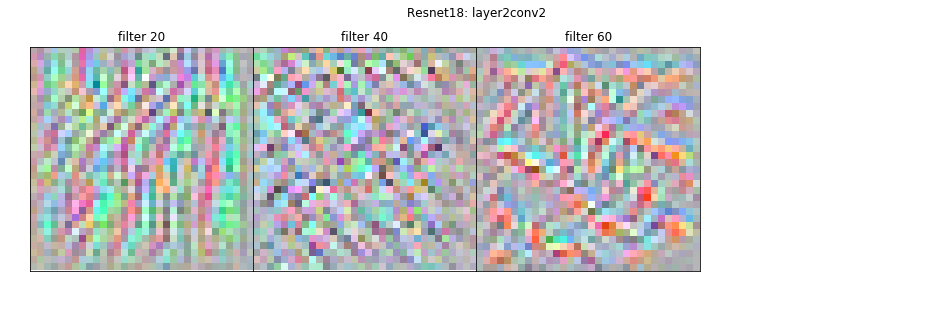

In [32]:
g_ascent.visualize(layer2conv2, layer2conv2_filters, title='Resnet18: layer2conv2')